In [1]:
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

### Download & visualize images

In [2]:
working_dir = 'ellipses/'
files = next(os.walk(working_dir))[2]
files = list(filter(lambda x: x.endswith('.jpg'), files))

In [3]:
images = []
for file in files:
     #read images from data folder
    img = cv2.imread(os.path.join(working_dir, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    images.append(img)

In [4]:
def visualize(images):
    for img in images:
        plt.figure(figsize=(15, 15))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

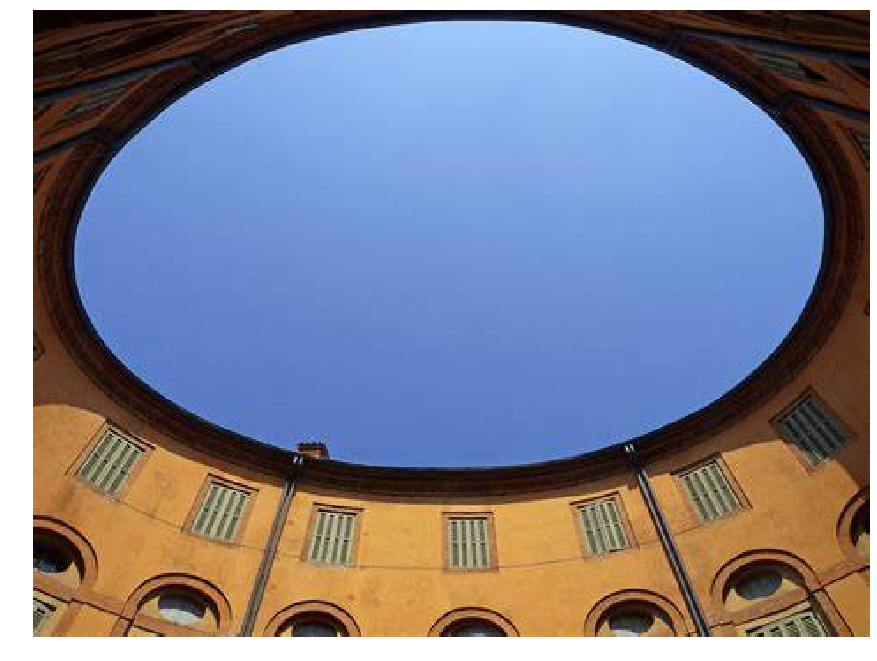

In [5]:
visualize(images)

### Solution

In [8]:
class Ellipse(object):
    '''Ellipses finding algorithm'''
    def __init__(self, points):
        
        self.points = np.array(points, dtype=np.double)
        
        #self.max_values = self.points.max(axis=0)
        #self.min_values = self.points.min(axis=0)
        
    def find_ellipse(self):
        # create M matrix
        matrix = []
        for point in self.points:
            matrix.append([point[0]**2, 2 * point[0] * point[1], point[1]**2, 2 * point[0], 2 * point[1], 1])
    
        # find the M.T M
        matrix = np.array(matrix, dtype=np.double)
        matrix = matrix.transpose() @ matrix
        
        # find the vector of coefficients
        _, _, V = np.linalg.svd(matrix)
        
        # set E matrix of the ellipse
        R = V[-1, :]
        R /= R[0]
        self.E = np.array([[R[0], R[1], R[3]],
                           [R[1], R[2], R[4]],
                           [R[3], R[4], R[5]]], np.double)
        
    def draw_ellipse(self, n_points=200):
    
        points = []

        u, s, v = np.linalg.svd(self.E)
        H = np.linalg.inv(np.diag(np.sqrt(s)) @ u.transpose())
        
        # sample angles in radians
        alphas = np.linspace(0, 2 * np.pi, num=n_points)

        for alpha in alphas:
            
            # get point on the ellipse
            
            res = H @ np.array([np.sin(alpha), np.cos(alpha), 1.0])
            res = res[:2] / res[2]
            
            res = res.astype(np.int32)
            points.append(tuple(res))

        return points       

In [9]:
def max_deviation(points, sigma_first=-1, sigma_last=1, n_trials=50, n_points=100):
    # compute max deviation in the case of white noise
    
    sigmas = np.linspace(sigma_first, sigma_last, num=n_points)
    points = np.array(points, dtype=np.double)
    
    # precompute ideal ellipse
    ellipse_ideal = Ellipse(points)
    ellipse_ideal.find_ellipse()
    ideal_points = ellipse_ideal.draw_ellipse(n_points)
    
    distances = []
    
    for sigma in sigmas:
        
        dist = 0
        for n in range(n_trials):
            
            points_with_noise = points + sigma * np.random.randn(*points.shape)
            #points_with_noise = points.astype(np.int32)
            
            # for each loop compute noised ellipse
            ellipse = Ellipse(points_with_noise)
            ellipse.find_ellipse()
            noise_points = ellipse.draw_ellipse(n_points)
            
            # find the maximal distance from
            # ideal ellipse to noised
            matrix = distance_matrix(ideal_points, noise_points)
            dist += np.sqrt(matrix.min(axis=0).max())
            
        dist /= n_trials
        distances.append(dist)
        
    distances = np.array(distances)
    
    return sigmas, distances

### Find the 7 keypoints of the desired ellipse on the image:

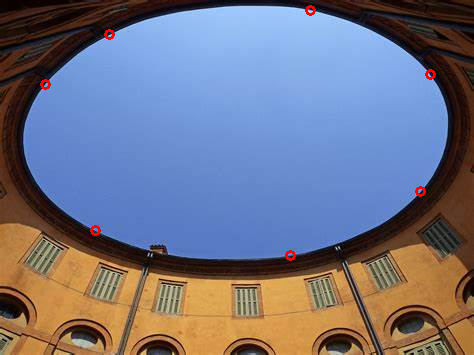

In [10]:
img = np.array(images[0]).copy()

points = [(430, 74),
          (420, 191),
          (290, 255),
          (95, 230),
          (45, 84),
          (109, 34),
          (310, 10)]

for point in points:
    cv2.circle(img, point, 4, (255, 0, 0), 2)
Image.fromarray(img)

In [11]:
ellipse = Ellipse(points)
ellipse.find_ellipse()
ps = ellipse.draw_ellipse(200)

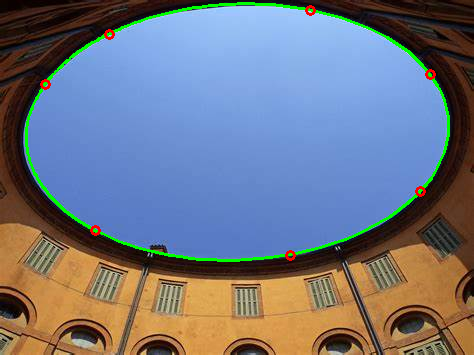

In [12]:
img = np.array(images[0]).copy()

for i in range(1, len(ps)):
    cv2.line(img, ps[i-1], ps[i], (0, 255, 0), 2)
for point in points:
    cv2.circle(img, point, 4, (255, 0, 0), 2)

Image.fromarray(img)

### Plot maximal deviation depends on standard deviation of the errors:

In [ ]:
%%time
sigmas, dists = max_deviation(points, 0, 8)

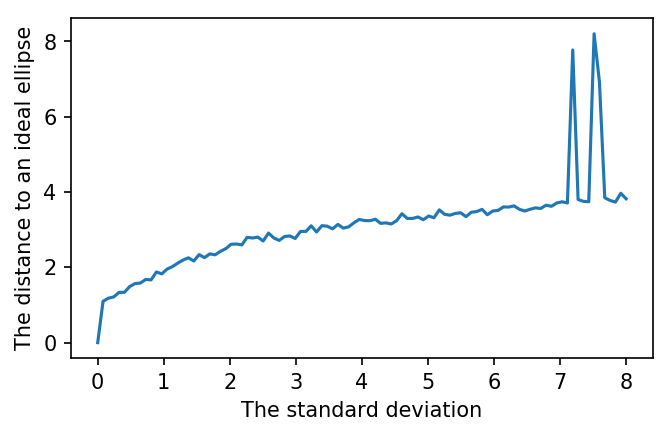

In [479]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(sigmas, dists)
plt.xlabel('The standard deviation')
_ = plt.ylabel('The distance to an ideal ellipse')